View results

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('font', family='DejaVu Sans')
%matplotlib inline

import pickle
import pymc3 as pm

def load_model(fn):
    with pm.Model():
        with open(fn, 'rb') as f:
            return pickle.load(f)
        
model1 = load_model('model1.pickle')
model2 = load_model('model2.pickle')
model3 = load_model('model3.pickle')

/home/rick/anaconda3/envs/bayesian-mfa-paper/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from steel_processes import define_processes
processes = define_processes()

In [3]:
from trace_sankey_helpers import show_sample, animate_samples, show_variance, flows_from_trace, save_variance
from steel_sdd import sdd

def pidx(pid):
    return list(processes.keys()).index(pid)

In [4]:
sum(p.nparams for p in model1.processes.values()) + len(model1.possible_inputs)

100

## Prior

In [5]:
with model1.model:
    trace1 = pm.backends.text.load('traces/trace1')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Samples from prior:

In [6]:
animate_samples(processes, model1.possible_inputs, trace1, sdd, rescale=True)

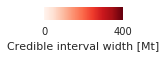

In [7]:
flows1 = flows_from_trace(processes, model1.possible_inputs, trace1)
show_variance(flows1, sdd, vlim=(0, 400)).auto_save_png('figures/prior_uncertainty_abs.png')

Sample prior distributions:

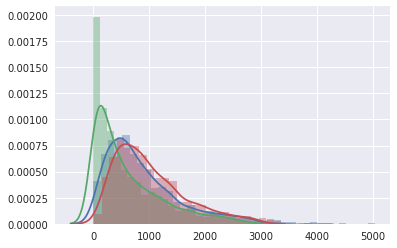

In [8]:
sns.distplot(trace1['X'][:, pidx('OBF')], kde_kws=dict(clip=(0, 3000)))
sns.distplot(trace1['X'][:, pidx('OHF')], kde_kws=dict(clip=(0, 3000)))
sns.distplot(trace1['X'][:, pidx('EAF')], kde_kws=dict(clip=(0, 3000)));

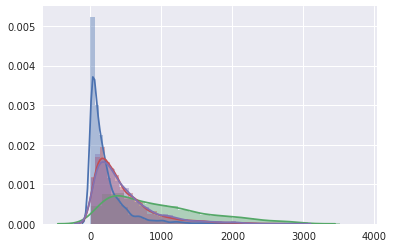

In [9]:
sns.distplot(trace1['X'][:, pidx('CCS')], kde_kws=dict(clip=(0, 3000)))
sns.distplot(trace1['X'][:, pidx('IC')], kde_kws=dict(clip=(0, 3000)))
sns.distplot(trace1['X'][:, pidx('CCBT')], kde_kws=dict(clip=(0, 3000)))
sns.distplot(trace1['X'][:, pidx('CCBM')], kde_kws=dict(clip=(0, 3000)));

## Posterior stage 1

In [10]:
with model2.model:
    trace2 = pm.backends.text.load('traces/trace2')

In [11]:
animate_samples(processes, model2.possible_inputs, trace2, sdd, rescale=False)

In [12]:
flows2 = flows_from_trace(processes, model2.possible_inputs, trace2)

Adjust the colormap to exclude the palest colour:

In [13]:
from palettable.colorbrewer import sequential
from matplotlib.colors import LinearSegmentedColormap
palette = LinearSegmentedColormap.from_list('', sequential.YlGnBu_9_r.mpl_colors[:-1])

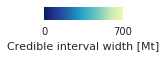

In [14]:
s = show_variance(flows2, sdd, vlim=(0, 700), palette=palette).auto_save_png('figures/stage1_uncertainty_abs.png')
plt.gcf().savefig('figures/stage1_uncertainty_abs_colorbar.svg', bbox_inches='tight')
s

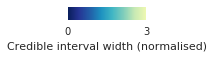

In [15]:
show_variance(flows2, sdd, vlim=(0, 3), palette=palette, normed=True)

In [16]:
%%html
<style>.sankey .link { opacity: 1 !important; }</style>

In [17]:
def plot_flow(trace, src, tgt, value, prior=None):
    if not isinstance(trace, (tuple, list)): trace = [trace]
    N = len(trace)
    fig, ax = plt.subplots(1, N, figsize=(3 * N, 2), squeeze=False, sharex=True, sharey=True)
    for i, tr in enumerate(trace):
        if prior is not None:
            prior_values = prior['F'][:, pidx(src), pidx(tgt)]
            sns.distplot(prior_values, color='gray', kde_kws=dict(clip=(0, 2000)), ax=ax[0, i])
        values = tr['F'][:, pidx(src), pidx(tgt)]
        sns.distplot(values, kde_kws=dict(clip=(0, 2000)), ax=ax[0, i])
        #plt.hist(trace2['F'][:, pidx('IC'), pidx('ingots')], bins=20);
        ax[0, i].set_title(u'{} → {}'.format(processes[src].name, processes[tgt].name))
        ax[0, i].axvline(values.mean(), c='k', alpha=0.5)
        ax[0, i].axvline(value, c='r');
        
def plot_flows(trace, src, targets, refs, prior=None):
    N = len(targets)
    fig, ax = plt.subplots(1, N, figsize=(3 * N, 2.5), squeeze=False, sharex=True, sharey=True)
    for i, tgt in enumerate(targets):
        if prior is not None:
            prior_values = prior['F'][:, pidx(src), pidx(tgt)]
            sns.distplot(prior_values, color='gray', kde_kws=dict(clip=(0, 2000)), ax=ax[0, i])
        values = trace['F'][:, pidx(src), pidx(tgt)]
        sns.distplot(values, kde_kws=dict(clip=(0, 2000)), ax=ax[0, i])
        ax[0, i].set_title(processes[tgt].name)
        ax[0, i].axvline(values.mean(), c='k', alpha=0.5)
        ax[0, i].axvline(refs[i], c='r');
    fig.suptitle(u'{} → ...'.format(processes[src].name))
    fig.subplots_adjust(top=0.8)

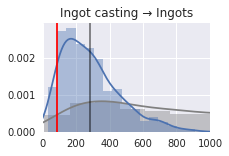

In [18]:
plot_flow(trace2, 'IC', 'ingots', 89, prior=trace1); plt.xlim(0, 1000);

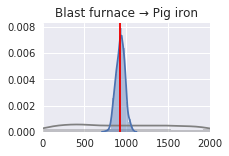

In [19]:
plot_flow(trace2, 'BF', 'PI', 928.4, prior=trace1); plt.xlim(0, 2000);

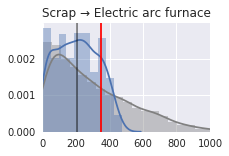

In [20]:
plot_flow(trace2, 'S', 'EAF', 351, prior=trace1); plt.xlim(0, 1000);

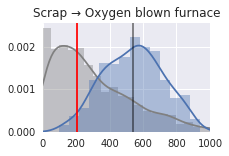

In [21]:
plot_flow(trace2, 'S', 'OBF', 206, prior=trace1); plt.xlim(0, 1000);

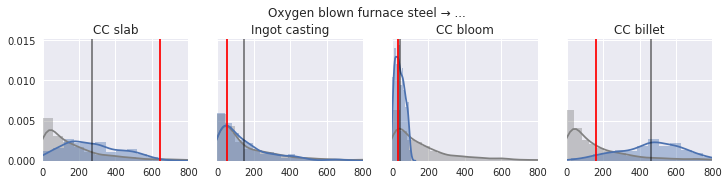

In [22]:
plot_flows(trace2, 'OBFS', ['CCS', 'IC', 'CCBM', 'CCBT'],
           [646.7, 53.0, 32.8, 159.1], prior=trace1); plt.xlim(0, 800);

Bloom is well pinned down because it all goes to the section mill:

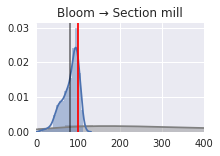

In [23]:
plot_flow(trace2, 'bloom', 'SEM', 99.2, prior=trace1); plt.xlim(0, 400);

Billet goes to RBM and HSM

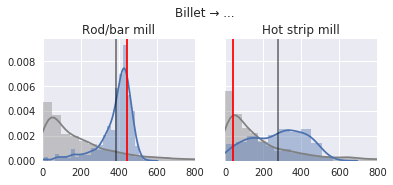

In [24]:
plot_flows(trace2, 'billet', ['RBM', 'HSM'], [442.2, 41.8], prior=trace1); plt.xlim(0, 800);

The RBM is well solved, since it mostly comes from billet, but the HSM mostly uses slab (which goes to the plate mill too)

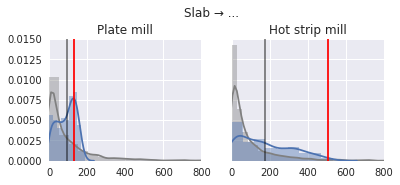

In [25]:
plot_flows(trace2, 'slab', ['PLM', 'HSM'], [132.0, 508.0], prior=trace1); plt.xlim(0, 800);

Most of the HSM input is slab, leaving little billet, whereas initially the split was assumed to be more equal (300ish). Did the prior distributions leave the possibility open enough that slab -> HSM would be so high?

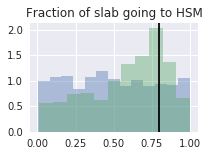

In [26]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.distplot(trace1['param_slab'][:, 0], kde=False, ax=ax, norm_hist=True)
sns.distplot(trace2['param_slab'][:, 0], kde=False, ax=ax, norm_hist=True)
ax.axvline(508.0 / (508.0 + 132.0), c='k')
ax.set(title='Fraction of slab going to HSM');

The allocation looks fine -- before it was uniformly distributed, now it's estimated at 80%, which is about right. So the remaining uncertainty about the slab -> HSM flow must come from the CCS throughput, which comes from the OBF.

How is the OBF output allocated?

/home/rick/Dropbox/useless/Projects/Bayesian Sankeys/5. Case study - global steel/bayesian-mfa-mcmc/barycentric_plot.py:43: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(1)


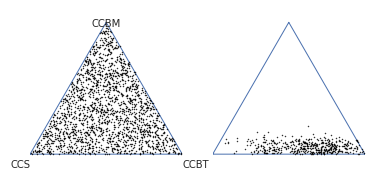

In [27]:
shares1 = trace1['param_OBFS'][:, [0, 1, 2]]   # ignore IC?
shares1 /= shares1.sum(axis=1, keepdims=True)

shares2 = trace2['param_OBFS'][:, [0, 1, 2]]   # ignore IC?
shares2 /= shares2.sum(axis=1, keepdims=True)

from barycentric_plot import plot_points
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
plot_points(shares1, ax=ax[0], labels=['CCS', 'CCBT', 'CCBM'])
plot_points(shares2, ax=ax[1])

Definitely, very little to blooms. Slab/billet split is quite open, favours billets.

## Posterior stage 2

In [28]:
with model3.model:
    trace3 = pm.backends.text.load('traces/trace3')

In [29]:
animate_samples(processes, model3.possible_inputs, trace3, sdd, rescale=False)

In [30]:
flows3 = flows_from_trace(processes, model3.possible_inputs, trace3)

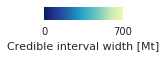

In [31]:
show_variance(flows3, sdd, vlim=(0, 700), palette=palette).auto_save_png('figures/stage2_uncertainty_abs.png')

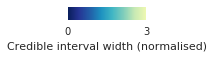

In [32]:
show_variance(flows2, sdd, vlim=(0, 3), palette=palette, normed=True)

In [33]:
import json
with open('figures/stage1_uncertainty_abs.json', 'wt') as f:
    json.dump(save_variance(flows2, sdd, vlim=(0, 700), palette=palette), f)
with open('figures/stage2_uncertainty_abs.json', 'wt') as f:
    json.dump(save_variance(flows3, sdd, vlim=(0, 700), palette=palette), f)

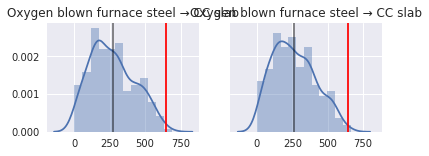

In [34]:
plot_flow([trace2, trace3], 'OBFS', 'CCS', 646)

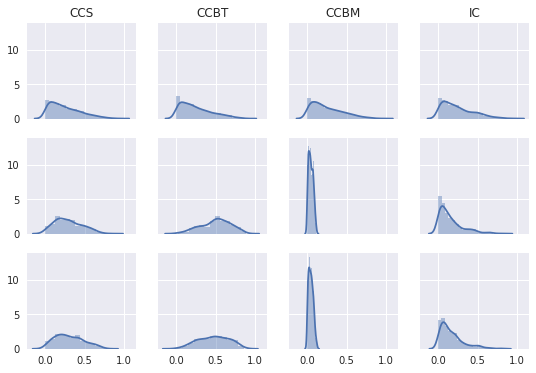

In [35]:
fig, ax = plt.subplots(3, 4, figsize=(9, 6), sharex=True, sharey=True)
for j, tr in enumerate([trace1, trace2, trace3]):
    for i in range(4):
        sns.distplot(tr['param_OBFS'][:, i], ax=ax[j, i], kde_kws=dict(clip=(0, 1)));
        ax[0, i].set_title(processes['OBFS'].outputs[i])

In [36]:
def plot_flows3(traces, src, tgt, ref=None, max=None):
    assert len(traces) == 3
    kde_kws = {}
    if max is not None:
        kde_kws['clip'] = (0, max)
        
    colours = ['xkcd:gray', 'xkcd:sage', 'steelblue']
    labels = ['Prior', 'Stage 1', 'Stage 2']
    
    fig, ax = plt.subplots(figsize=(4, 3))
    for tr, c, l in zip(traces, colours, labels):
        values = tr['F'][:, pidx(src), pidx(tgt)]
        #sns.distplot(values, color=c, kde_kws=kde_kws, ax=ax, label=l)
        sns.distplot(values, color=c, kde=False, norm_hist=True, hist_kws=dict(alpha=0.8), ax=ax, label=l)
    ax.set_title(u'{} → {}'.format(processes[src].name, processes[tgt].name))
    #ax.axvline(values.mean(), c='k', alpha=0.5)
    if ref is not None:
        ax.axvline(ref, c='r')
    if max is not None:
        ax.set_xlim(0, max)
    ax.set_yticks([])
    plt.legend()

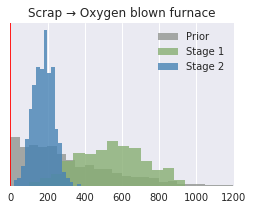

In [37]:
plot_flows3([trace1, trace2, trace3], 'S', 'OBF', 0, max=1200)

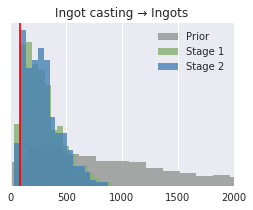

In [38]:
plot_flows3([trace1, trace2, trace3], 'IC', 'ingots', 88.7, max=2000)
plt.savefig('figures/learning_flow_IC_ingots.png')

In [39]:
def plot_alloc3(traces, src, tgt, ref=None, max=None):
    assert len(traces) == 3
    kde_kws = {}
    if max is not None:
        kde_kws['clip'] = (0, max)
        
    colours = ['gray', 'xkcd:sage', 'steelblue']
    labels = ['Prior', 'Stage 1', 'Stage 2']
    
    fig, ax = plt.subplots(figsize=(4, 3))
    for tr, c, l in zip(traces, colours, labels):
        j = processes[src].outputs.index(tgt)
        values = tr['param_{}'.format(src)][:, j]
        sns.distplot(values * 100, color=c, kde=False, norm_hist=True, hist_kws=dict(alpha=0.8), ax=ax, label=l)
    ax.set_title(u'{} → {}'.format(processes[src].name, processes[tgt].name))
    #ax.axvline(values.mean(), c='k', alpha=0.5)
    if ref is not None:
        ax.axvline(ref, c='r')
    if max is not None:
        ax.set_xlim(0, max)
    plt.legend(loc='best')
    ax.set_yticks([])
    ax.set_xticklabels(['0', '20', '40', '60', '80', '100%'])

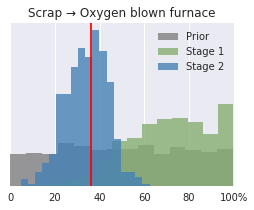

In [40]:
plot_alloc3([trace1, trace2, trace3], 'S', 'OBF', 36, max=100)

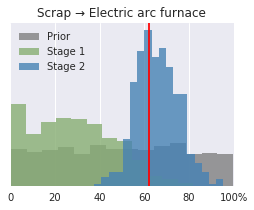

In [41]:
plot_alloc3([trace1, trace2, trace3], 'S', 'EAF', 62, max=100)

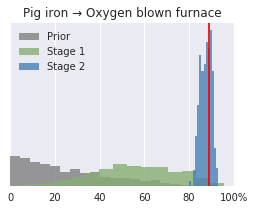

In [42]:
plot_alloc3([trace1, trace2, trace3], 'PI', 'OBF', 89, max=100)
plt.savefig('figures/learning_alloc_PI_OBF.png')

In [43]:
def plot_alloc3_subplots(traces, src, tgt, ref=None, max=None):
    assert len(traces) == 3
    kde_kws = {}
    if max is not None:
        kde_kws['clip'] = (0, max)
        
    colours = ['gray', 'xkcd:sage', 'steelblue']
    labels = ['Prior', 'Stage 1', 'Stage 2']
    
    fig, ax = plt.subplots(3, figsize=(4, 3), sharex=True, sharey=True)
    for a, tr, c, l in zip(ax, traces, colours, labels):
        j = processes[src].outputs.index(tgt)
        values = tr['param_{}'.format(src)][:, j]
        sns.distplot(values * 100, color=c, kde=False, bins=np.arange(0, 101, 5), norm_hist=True, hist_kws=dict(alpha=0.8), ax=a, label=l)
        a.set_ylabel(l)
        if ref is not None:
            a.axvline(ref, c='r')
        a.set_yticks([])

    fig.suptitle(u'{} → {}'.format(processes[src].name, processes[tgt].name))
    #ax.axvline(values.mean(), c='k', alpha=0.5)
    if max is not None:
        ax[0].set_xlim(0, max)
    #plt.legend(loc='best')
    ax[2].set_xticklabels(['0', '20', '40', '60', '80', '100%'])

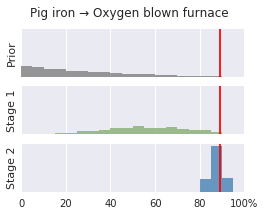

In [44]:
plot_alloc3_subplots([trace1, trace2, trace3], 'PI', 'OBF', 89, max=100)
plt.savefig('figures/learning_alloc_PI_OBF_subplots.png')

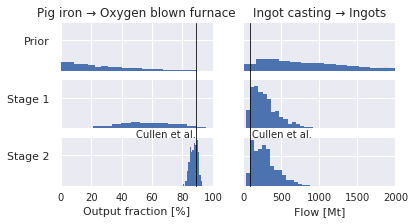

In [45]:
fig, ax = plt.subplots(3, 2, sharex='col', sharey='col', figsize=(6, 3))
traces = [trace1, trace2, trace3]

def distplot(x, ax):
    sns.distplot(x, ax=ax, kde=False, norm_hist=True, hist_kws=dict(alpha=1, lw=0))

for i, tr in enumerate(traces):
    distplot(tr.param_PI[:, processes['PI'].outputs.index('OBF')] * 100, ax[i, 0])
    distplot(tr.F[:, pidx('IC'), pidx('ingots')], ax[i, 1])
    for j in range(len(ax[i])):
        ax[i, j].set_yticklabels([])
    ax[i, 0].axvline(89, color='k', lw=1, alpha=0.8, ymin=0, ymax=1.2 if i else 1, zorder=10, clip_on=False)
    ax[i, 1].axvline(88.7, color='k', lw=1, alpha=0.8, ymin=0, ymax=1.2 if i else 1, zorder=10, clip_on=False)

ax[2, 0].annotate('Cullen et al.', (89, 1), xycoords=('data', 'axes fraction'), ha='right',
                 fontsize=10)
ax[2, 1].annotate('Cullen et al.', (120, 1), xycoords=('data', 'axes fraction'), ha='left',
                 fontsize=10)
    
ax[0, 0].set(title='Pig iron → Oxygen blown furnace', xlim=(0, 100))
ax[0, 1].set(title='Ingot casting → Ingots', xlim=(0, 2000))
ax[-1, 0].set(xlabel='Output fraction [%]')
ax[-1, 1].set(xlabel='Flow [Mt]')
ax[0, 0].set_ylabel('Prior', rotation=0, ha='right')
ax[1, 0].set_ylabel('Stage 1', rotation=0, ha='right')
ax[2, 0].set_ylabel('Stage 2', rotation=0, ha='right')
fig.savefig('figures/learning_histograms.pdf', bbox_inches='tight');